Este proyecto se puede ver como una continuación a uno anterior en el que se intentaba predecir el logaritmo base 10 de la población con base a las condiciones de vivienda. Este proyecto intentará hacer algo similar para predecir si un asentamiento se considera zona rural o urbana de acuerdo con la definición del INEGI, donde a partir de 2,500 personas se considera ciudad.

El proceso de depuración de la base de datos, y las interacciones se reciclarán por completo del [proyecto anterior](https://ethan-r-r.github.io/Modelo-Poblacion-por-condiciones-de-vivienda/) en donde se explica más a detalle. 

Empezaremos importando la base de datos y haciendo procesos para eliminar espacios vacíos, borrar variables de poco interés, etc.


In [84]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

df = pd.read_csv("conjunto_de_datos_iter_19CSV20.csv")

#https://sparkbyexamples.com/pandas/pandas-delete-rows-based-on-column-value/#:~:text=To%20delete%20rows%20based%20on%20specific%20column%20values%20in%20a,method%20to%20remove%20those%20rows.
df = df.drop(df[df["LATITUD"].isnull()].index)

#variables cualitativas o redundantes se dejaron en la base de datos por si se quiere revisar individualmente algo de las caracteristicas de la zona
df = df.drop(columns = ['ENTIDAD','NOM_ENT','MUN','LOC','NOM_MUN','LONGITUD','LATITUD','ALTITUD'])
#Trabajaremos solo con las viviendas particulares. 
df = df.drop(columns = ['VIVTOT','TVIVHAB','TVIVPAR','OCUPVIVPAR','TVIVPARHAB'])
df.drop('NOM_LOC',inplace = True,axis=1)

print("Tamaño original ", df.shape)
#la siguiente linea se genero con ayuda de chatgpt
#añade una columna que incluye la cantidad de huecos que tiene cada fila
df["DatosVacios"] = df.isnull().sum(axis=1)
print(df.DatosVacios)



df.drop(df[df["DatosVacios"]>=(30)].index, inplace=True)
print("Observaciones eliminando las que tienen menos de la mitad de los datos", df.shape)
#Nos quedan solo 2135 observaciones que cumplen el criterio
df.drop(df[df["DatosVacios"]>(0)].index, inplace=True)
print("Observaciones eliminando las que no tienen todos los datos ", df.shape)
print(df.columns)


Tamaño original  (4821, 54)
4        0
5       53
6       53
7       53
8       53
        ..
4966    53
4967    53
4968    53
4969    53
4970    53
Name: DatosVacios, Length: 4821, dtype: int64
Observaciones eliminando las que tienen menos de la mitad de los datos (1990, 55)
Observaciones eliminando las que no tienen todos los datos  (1990, 55)
Index(['POBTOT', 'TOTHOG', 'HOGJEF_F', 'HOGJEF_M', 'POBHOG', 'PHOGJEF_F',
       'PHOGJEF_M', 'VIVPARH_CV', 'VIVPAR_DES', 'VIVPAR_UT', 'PROM_OCUP',
       'PRO_OCUP_C', 'VPH_PISODT', 'VPH_PISOTI', 'VPH_1DOR', 'VPH_2YMASD',
       'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_C_ELEC', 'VPH_S_ELEC',
       'VPH_AGUADV', 'VPH_AEASP', 'VPH_AGUAFV', 'VPH_TINACO', 'VPH_CISTER',
       'VPH_EXCSA', 'VPH_LETR', 'VPH_DRENAJ', 'VPH_NODREN', 'VPH_C_SERV',
       'VPH_NDEAED', 'VPH_DSADMA', 'VPH_NDACMM', 'VPH_SNBIEN', 'VPH_REFRI',
       'VPH_LAVAD', 'VPH_HMICRO', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI',
       'VPH_RADIO', 'VPH_TV', 'VPH_PC', 'VPH_TELEF', 'V

Igual que en el proyecto anterior, es mucho más interesante hacer predicciones de la población utilizando la proporción de viviendas con una característica, que directamente usar el número de viviendas con dicha característica (excepto las que representan otros valores como el promedio de ocupantes por vivienda y el promedio de ocupantes por cuarto). 

In [85]:
#Esta linea de codigo fue hecha con ayuda de CHATGPT
excluirDiv = ['PROM_OCUP','PROM_OCUP_C','VIVPARH_CV','POBTOT','NOM_LOC']
df.loc[:,~df.columns.isin(excluirDiv) ] = df.loc[:,~df.columns.isin(excluirDiv)].div(df['VIVPARH_CV'],axis=0)
print(df.head())
df.drop('VIVPARH_CV',inplace = True,axis=1)


    POBTOT    TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  PHOGJEF_F  PHOGJEF_M  \
4     1992  1.000000  0.301471  0.698529  3.661765   1.029412   2.632353   
13      15  1.000000  0.000000  1.000000  5.000000   0.000000   5.000000   
16      53  1.000000  0.214286  0.785714  3.785714   0.857143   2.928571   
17     870  1.013216  0.259912  0.753304  3.832599   0.955947   2.876652   
21    2080  1.001325  0.242384  0.758940  2.747020   0.545695   2.201325   

    VIVPARH_CV  VIVPAR_DES  VIVPAR_UT  ...   VPH_CEL  VPH_INTER  VPH_STVP  \
4        544.0    0.306985   0.154412  ...  0.920956   0.476103  0.474265   
13         3.0    1.666667   0.000000  ...  1.000000   0.000000  0.333333   
16        14.0    0.928571   0.285714  ...  1.000000   0.285714  0.285714   
17       227.0    0.264317   0.215859  ...  0.960352   0.370044  0.409692   
21       755.0    0.605298   0.437086  ...  0.876821   0.500662  0.617219   

    VPH_SPMVPI   VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  \
4  

Los valores atípicos ya se trataron en el proyecto anterior, donde se concluyó que todos los valores dentro de la base de datos eran realistas y muy poco probable que se deban a un error. 

Aquí empiezan las diferencias. En el proyecto anterior la variable de salida era la transformación del logaritmo base 10 de la población. Esto con la intención de linealizar más la relación entre las proporciones de viviendas con una característica y la población total. Ahora no solo no vamos a aplicar el logaritmo, si no que vamos a binarizar la variable para que cuente la cantidad de localidades que se pueden considerar urbanas (población total de más de 2500 personas)


In [86]:
#Crear data frame localidades que se pueden considerar ciudad
Rural = df.POBTOT <=2500
Urbano =pd.DataFrame({"Urbano":1-Rural})

#concatenar al dataframe original
df = pd.concat([df,Urbano],axis=1)

df.drop('POBTOT',inplace = True,axis=1)
df.drop('DatosVacios',inplace = True,axis=1)
print(df.Urbano.value_counts())
print(df.head())



Urbano
0    1901
1      89
Name: count, dtype: int64
      TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  PHOGJEF_F  PHOGJEF_M  VIVPAR_DES  \
4   1.000000  0.301471  0.698529  3.661765   1.029412   2.632353    0.306985   
13  1.000000  0.000000  1.000000  5.000000   0.000000   5.000000    1.666667   
16  1.000000  0.214286  0.785714  3.785714   0.857143   2.928571    0.928571   
17  1.013216  0.259912  0.753304  3.832599   0.955947   2.876652    0.264317   
21  1.001325  0.242384  0.758940  2.747020   0.545695   2.201325    0.605298   

    VIVPAR_UT  PROM_OCUP  PRO_OCUP_C  ...   VPH_CEL  VPH_INTER  VPH_STVP  \
4    0.154412       3.66    0.001654  ...  0.920956   0.476103  0.474265   
13   0.000000       5.00    0.556667  ...  1.000000   0.000000  0.333333   
16   0.285714       3.79    0.097143  ...  1.000000   0.285714  0.285714   
17   0.215859       3.78    0.004714  ...  0.960352   0.370044  0.409692   
21   0.437086       2.74    0.000887  ...  0.876821   0.500662  0.617219   

    VPH_S

Se puede observar un pesado desbalance de datos. Hay muchas más localidades rurales que urbanas. Más adelante se trabajará para compensar eso, por el momento solo separaremos los datos entre entrenamiento y prueba verificando que esa proporción se mantenga tanto en datos de entrenamiento como de prueba. 
 

In [87]:
# Importar función
from sklearn.model_selection import train_test_split
# Dividir datos
Y = df.Urbano
X = df.drop("Urbano",axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=919)
# Imprimir conteo en entrenamiento
print(Y.value_counts())
print(Y_train.value_counts())

# Imprimir conteo en prueba
print(Y_test.value_counts())
print(X_train.shape)

Urbano
0    1901
1      89
Name: count, dtype: int64
Urbano
0    1522
1      70
Name: count, dtype: int64
Urbano
0    379
1     19
Name: count, dtype: int64
(1592, 52)


Tanto los valores de entrenamiento como los valores de prueba tienen una proporción  de datos similar; aproximadamente el 20% de las localidades son urbanas.

Ahora, trabajar con las 53 variables podría ser muy complicado, por lo que se procederá a hacer una selección de características utilizando la función SequentialFeatureSelector de mlxtend. Haremos solamente el proceso de selección hacia adelante, y le pediremos a  la función le que delimite de 2 a 10 variables, se harán 5 folds en la validación cruzada, cómo métrica de scoring se usará el f1 por el desbalance de datos. 

Dentro del modelo que se utilizará para la selección de características añadimos el peso de clase balanceado para compensar el desbalance de datos que existe. 


In [88]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

#model = LogisticRegression(class_weight= "balanced")
#subX = SequentialFeatureSelector(model, k_features=(2,10),forward = True, scoring = "f1", cv = 5).fit(X_train,Y_train)
#print("Variables seleccionadas", subX.k_feature_names_)
#NewIndx = list(subX.k_feature_idx_)
#XNew = X_train.iloc[:,NewIndx[:]]
#Para fácilitar el proceso, corrí una sola vez el proceso de selección de características y guarde las variables acá. Así podría correr el código varias veces sin esperar 40 segundos extra 


ListaDeCar = ['VIVPAR_DES', 'VIVPAR_UT', 'VPH_CISTER', 'VPH_SPMVPI']
#Linea generada con ayuda de IA
XNew = X_train.iloc[:,X_train.columns.get_indexer(ListaDeCar)]
print(X_train.columns.get_indexer(ListaDeCar))
print(XNew.columns)




[ 6  7 23 46]
Index(['VIVPAR_DES', 'VIVPAR_UT', 'VPH_CISTER', 'VPH_SPMVPI'], dtype='object')


Curiosamente, Las variables son diferentes a las que la función eligió para la regresión lineal múltiple, aquí está que significa cada una. 

VIVPAR_DES_ Viviendas particulares deshabitadas.

VIVPAR_UT: Viviendas particulares de uso temporal.

VPH_CISTER: Viviendas particulares habitadas que tienen cisterna o aljibe. 

VPH_SMVPI: Viviendas particulares habitadas que tienen servicio de películas, música o videos de paga por Internet.

Procederemos a entrenar un modelo y medir su exactitud utilizando un método de validación cruzada con la librearía sklearn. El método de validación cruzada elegido es k-folds repetido (muchas iteraciones del kfolds), y se medirá la exactitud (accuracy) 

Se dividirán en 3 folds y se harán 10 iteraciones. 

Parte del código tomó inspiración de: 
[https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)





In [89]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedKFold(n_splits = 5, random_state=1042)
model1 = LogisticRegression(penalty= None,class_weight= "balanced")
scores = cross_val_score(model1,XNew,Y_train,scoring = 'accuracy',cv=cv)

print("Accuracy del modelo: ", np.mean(scores))


Accuracy del modelo:  0.9425186806253819


Tenemos una precisión del 94.2%, nuestro modelo tiene la capacidad de predecir con 
éxito el 94.2% de las veces si una localidad es urbana o rural con base a la proporción de características de vivienda.

Ahora se usará todo el subconjunto de entrenamiento para generar un modelo de predicción y analizar su matriz de confusión para distintos umbrales. 



In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
model= LogisticRegression(penalty = None, class_weight = "balanced").fit(XNew,Y_train)
#predecir la probabilidad de ser una clase
X_test = X_test.iloc[:,X_test.columns.get_indexer(ListaDeCar)]
Prob  = model.predict_proba(X_test)
print(Prob[0])



[9.99737487e-01 2.62512595e-04]


Ahora, vamos a probar la  sensibilidad, precisión y prueba f1 para distintos umbrales. Empezando con el 50/50


Clases: [0 1]
False
3579    0
1240    0
1477    0
1940    0
3709    0
Name: Urbano, dtype: int32


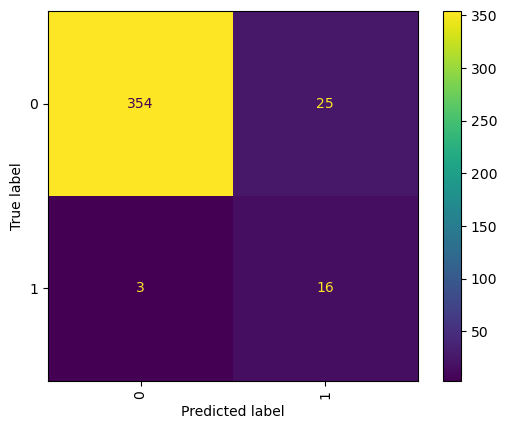

In [91]:
print("Clases:", model.classes_)  # Esta linea se generó con ayuda de IA
Pred_50 = Prob[:,1]>=0.5
print(Pred_50[0])
print(Y_test.head())
cm_50 = confusion_matrix(Y_test,Pred_50)

cmd(cm_50,display_labels = model.classes_).plot(xticks_rotation= "vertical")
plt.show()

La accuracy del modelo en los datos de prueba es de 0.9296, lo cual en un inicio pareciera estar muy bien, también tiene una especificidad muy alta, con un valor de 0.99. La precisión tiene un valor de 0.3902. La sensibilidad de este modelo es del 0.84. Es decir, aunque el modelo predice una gran proporción de localidades urbanas correctamente, también cataloga erróneamente a muchas localidades rurales como urbanas. El valor de f1 es de 0.532869. 
Esto es de esperarse, debido al desbalance de datos, aun cuando habíamos configurado al modelo para intentar compensarlo, afecta al desempeño.  

Podemos intentar variar el umbral para ver como cambian la precisión y la especificidad del modelo. Empezaremos con un umbral menos estricto. Ahora dará un positivo cada que la probabilidad sea mayor al 35%. 



False


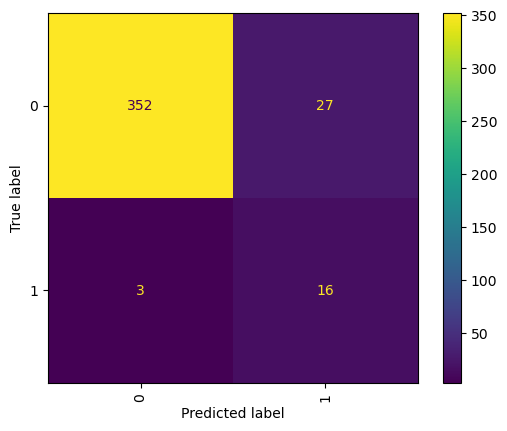

In [92]:
Pred_35 = Prob[:,1]>=0.35
print(Pred_35[0])
cm_35 = confusion_matrix(Y_test,Pred_35)
cmd(cm_35,display_labels = model.classes_).plot(xticks_rotation= "vertical")
plt.show()

Al ver la matriz de confusión del segundo umbral es evidente que no hubo un gran cambio significativo en el desempeño. 
La sensibilidad del segundo umbral es de 0.842105 La precisión del segundo umbral es de 0.372. El valor de f1 es de 0.516129. No es particularmente distinto del anterior umbral.

Ahora, se va a configurar un umbral más estricto que solo admite positivos cuando hay una probabilidad mayor al 90%


False


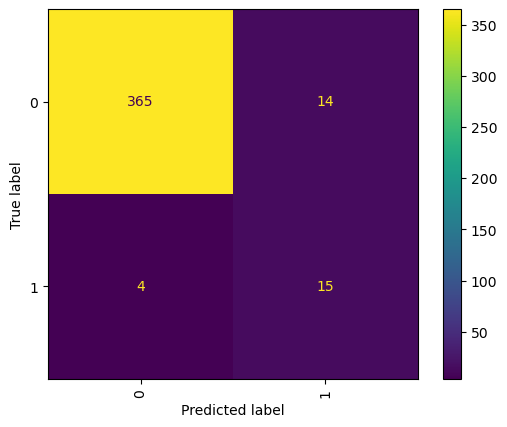

In [93]:
Pred_90 = Prob[:,1]>=0.9
print(Pred_90[0])
cm_90 = confusion_matrix(Y_test,Pred_90)
cmd(cm_90,display_labels = model.classes_).plot(xticks_rotation= "vertical")
plt.show()

El modelo con este umbral tiene una precisión de 0.517, una sensibilidad de 0.789, y una puntuación f1 de 0.625. 
El umbral más alto es el que tuvo un f1 score y una precisión más alta, sin embargo al costo de una sensibilidad más baja. En general ninguno de los umbrales tuvo un valor mayor a 0.7, esto muy probablemente se pueda deber al marcado desbalance de datos.
Otra forma de ver la calidad del modelo es mediante la curva ROC y su área bajo la curva. 


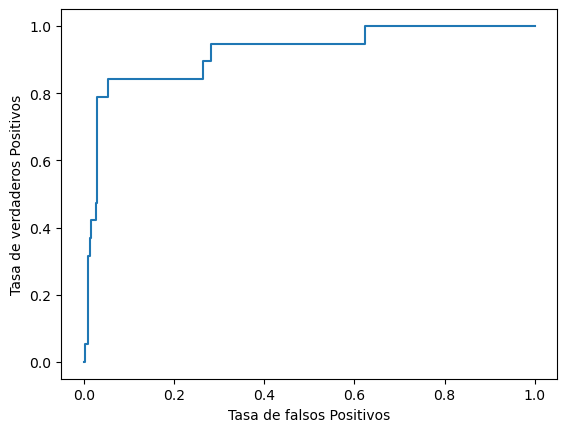

AUC 0.921399805582558


In [94]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds =roc_curve(Y_test,Prob[:,1])
plt.plot(fpr,tpr)
plt.xlabel('Tasa de falsos Positivos')
plt.ylabel('Tasa de verdaderos Positivos')
plt.show()
print('AUC',roc_auc_score(Y_test,Prob[:,1]))



 
La curva ROC y el valor del AUC de 0.9213 nos dice que el modelo tiene una buena calidad. Muy probablemente el escoger otros umbrales habría conseguido un mejor resultado. 
Ahora haremos un análisis de los coeficientes e inferencias sobre el modelo.


In [122]:
print("Predictor / Coeficiente")
print(np.column_stack([model.feature_names_in_.ravel(),model.coef_.ravel()])) #linea generada con ayuda de IA. 




Predictor / Coeficiente
[['VIVPAR_DES' -0.8033069049506003]
 ['VIVPAR_UT' -1.9652036173577243]
 ['VPH_CISTER' -32.545291768169804]
 ['VPH_SPMVPI' 29.741252047168338]]


Asumiendo que cada coeficiente es estadísticamente significativo podemos ver que variables afectan al logaritmo natural de los "odds" de que la localidad sea urbana sobre rural. Es decir, cada coeficiente influencia en que tan más probable sea que la localidad sea urbana por rural. 

Esto significa que, se puede asumir que entre mayor proporción de viviendas deshabitadas, viviendas de uso temporal y viviendas que usan una cisterna o aljibe, la probabilidad de que esa localidad sea urbana baja. Por otro lado, entre mayor sea la proporción de viviendas que cuentan con un sistema de películas, música o videos, mayor es la probabilidad de que sea una localidad urbana. 

Estos predictores tienen sentido, por ejemplo, es posible que en localidades rurales quizá no haya tanto acceso al drenaje y sea necesario usar una cisterna, por lo que la proporción de viviendas que la usan sube


